# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2 as cv
import seaborn as sns
import pandas as pd
%matplotlib inline

from src.legend import load_vocab
import src.map_drawing as map_drawing
import src.map_generator as mg
from models_src.Support import DatasetGenerator, plot_bbox_preds, plot_mask_preds
import os

from google.cloud import bigquery, storage
from google.auth import default

client = bigquery.Client(location='EU')

full_map_gen_args = {
    'map_args_path': "src/map_args.json",
    'minimap_args_path': "src/minimap_args.json",
    'map_concatenation_args_path': "src/map_concatenation_args.json",
    'parcel_input_args_path': "src/parcel_input_args.json",
    'bigquery_client': client
}
os.chdir(globals()['_dh'][0])

IN_COLAB = False
import os, importlib, sys
def reload_script(module_name):
    importlib.reload(sys.modules[module_name])
    os.chdir(globals()['_dh'][0])
    if IN_COLAB:
      os.chdir('GeoDoc/maps_vectorization')

In [2]:
vocab = load_vocab()

In [3]:
class cfg:
    ds_batch_size = 16
    target_size = 256
    parcel_input_batch_size = 512
    max_vertices_num = 50
    max_shapes_num = 30
    add_legend = 0
    add_minimap = 0
    output_type = 5
    fold_size = 512
    num_parallel_calls = 2
    test_mode = 1
    parcel_input_adjustment = True


In [4]:
fmg = mg.full_map_generator(cfg, vocab, **full_map_gen_args)

Parcels memory usage: 4.824 MB


In [5]:
dg = DatasetGenerator(cfg, fmg)

# BBox size distribution

In [5]:
dg.new_dataset(repeat=False, batch=False)

bboxes_collection = []
for features, labels in dg.ds:
    bboxes_collection.append(labels['bbox'])

bboxes = tf.concat(bboxes_collection, axis=0)
print(f'Number of BBoxes: {len(bboxes)}')


Generate new dataset
Number of BBoxes: 10568


(0.0, 50.0)

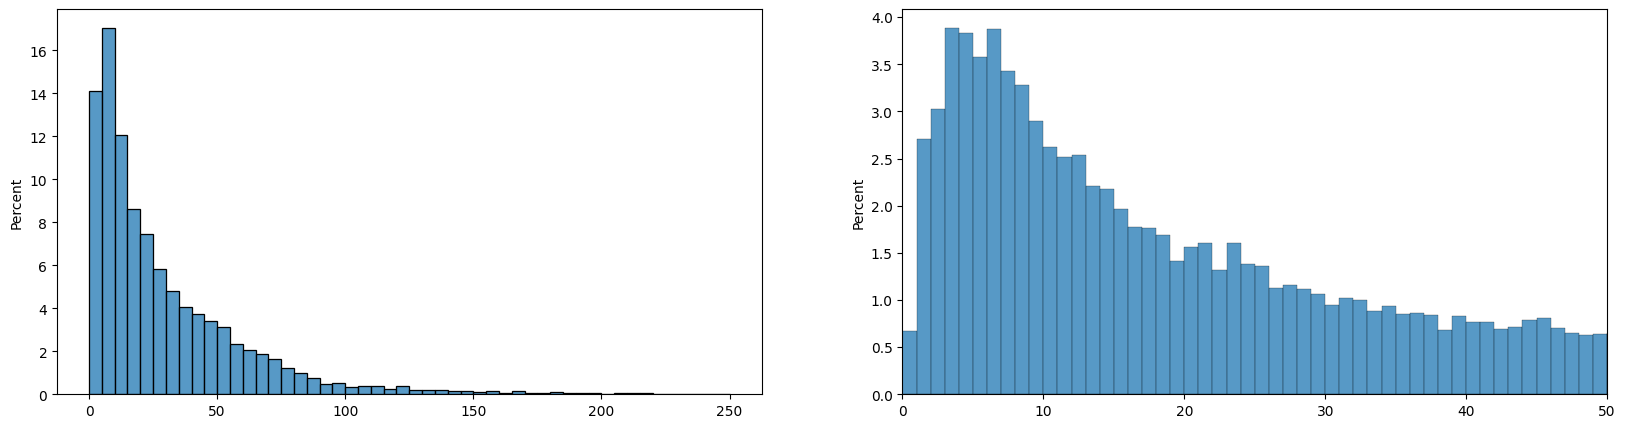

In [15]:
sizes1D = tf.concat([bboxes[:,2]-bboxes[:,0], bboxes[:,3]-bboxes[:,1]], axis=0).numpy()*cfg.target_size

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot(sizes1D, binwidth=5, cumulative=False, stat='percent', ax=ax[0])
sns.histplot(sizes1D, binwidth=1, cumulative=False, stat='percent', ax=ax[1])
ax[1].set_xlim(0,50)

# Default anchor function parameters optimization

### Default anchor function

In [6]:
class AnchorGenerator:
    def __init__(self,  
                 base_img_size=(256,256),
                 input_sizes=[64,32,16,8,4]
                 ):
        
        self.height, self.width = base_img_size
        self.input_sizes = input_sizes

        self.bbox_normalization = tf.constant(base_img_size*2, dtype=tf.float32)[tf.newaxis,tf.newaxis]

    def _bbox_decoding(self, bbox):
        YX, HW = bbox[...,:2], bbox[...,2:]*0.5

        return tf.concat([tf.clip_by_value(YX-HW, [0,0], [self.height, self.width]), tf.clip_by_value(YX+HW, [0,0], [self.height, self.width])], axis=-1)

    def _get_anchor_boxes(self, input_size, windows_num, anchor_size, window_size):
        H = W = input_size
        rows = tf.repeat(tf.reshape(tf.range(self.height, delta=self.height//H, dtype=tf.float32), (1,H,1,1)), W, axis=2)
        cols = tf.repeat(tf.reshape(tf.range(self.width, delta=self.width//W, dtype=tf.float32), (1,1,W,1)), H, axis=1)
        grid = tf.concat([cols, rows], axis=-1)

        pool = tf.keras.layers.AveragePooling2D(pool_size=window_size, padding='same')

        centers = tf.reshape(tf.reshape(tf.repeat(tf.expand_dims(pool(grid), axis=-2), self.anchors, axis=-2), (1,windows_num,2*self.anchors)), (1,windows_num*self.anchors,2))

        sizes = tf.stack([tf.constant([anchor_size/scale, anchor_size*scale], dtype=tf.float32) for scale in self.anchor_scales], axis=0) # [3,2]
        sizes =  tf.reshape(tf.repeat(sizes[tf.newaxis, tf.newaxis], windows_num, axis=1), (1, windows_num*self.anchors, 2))

        return self._bbox_decoding(tf.concat([centers, sizes], axis=-1))
    
    def _build(self, anchor_sizes, window_sizes):

        windows_nums = [math.ceil(input_size/window_size)**2 for input_size, window_size in zip(self.input_sizes, window_sizes)]
        #print(f'windows nums: {windows_nums}')

        self.anchor_bboxes = [self._get_anchor_boxes(*args) for args in zip(self.input_sizes, windows_nums, anchor_sizes, window_sizes)]

        self.anchor_output = tf.concat(self.anchor_bboxes, axis=1)

        anchors_num = sum(windows_nums)*self.anchors
        #print(f'all anchors num: {anchors_num}')

    def __call__(self, 
                 anchor_sizes=[24,48,64,156,224], 
                 anchor_scales=[0.5,1.0,2.0], 
                 window_sizes=[1,1,1,1,1],
                 bbox_normalization=True):
        
        self.anchors = len(anchor_scales)
        self.anchor_scales = anchor_scales

        self._build(anchor_sizes, window_sizes)

        if bbox_normalization:
            return self.anchor_output/self.bbox_normalization
        return self.anchor_output

### anchors scoring function

In [7]:
from models_src.Metrics import MultivariantHungarianLoss, IoUMetric

loss = MultivariantHungarianLoss(
                 classification=True,
                 bbox=True,
                 mask=False,
                 losses_weights=[0.0, 1.0, 0.0],
                 output_proposals=50,
                 output_mask_size=(256,256),
                 iou_weight=1.0,
                 bbox_regularization_rank=1,
                 mask_alpha=0.75,
                 mask_gamma=6,
                 mask_pool_size=16,
                 mask_class_pred=True,
                 class_smoothing=0.3,
                 unit_class_matrix=True,
                 reduction='none')

In [8]:
dg.new_dataset(repeat=False, batch=True)

bboxes_batches = []
pb = tf.keras.utils.Progbar(cfg.fold_size//cfg.ds_batch_size)
for features, labels in dg.ds:
    bboxes_batches.append(labels)
    pb.add(1)

print(f'Number of batches: {len(bboxes_batches)}')


Generate new dataset
32/32 [==============================] - 182s 6s/step
Number of batches: 32


In [370]:
anchors = AnchorGenerator( 
                input_sizes=[64,64,32,16,8,4]
                 )(
                anchor_sizes=[6,24,48,64,156,224], 
                anchor_scales=[0.5,1.0,2.0], 
                window_sizes=[1,1,1,1,1,1]
                )
print(anchors.shape)

(1, 28656, 4)


In [13]:
def calc_anchor_scores(loss, bboxes, anchors, batch_size=cfg.ds_batch_size, output_proposals=cfg.max_shapes_num):
    metric = tf.keras.metrics.Mean()
    scores = []
    anchors_batch = {'class': tf.ones((batch_size, anchors.shape[1])), 'bbox': tf.repeat(anchors, batch_size, axis=0)}
    pb = tf.keras.utils.Progbar(len(bboxes), stateful_metrics=['score'])
    for target_batch in bboxes:
        target_batch = {key: value[:,:output_proposals] for key, value in target_batch.items()}
        loss_value, _, _ = loss(target_batch, anchors_batch)
        metric.update_state(1-loss_value)
        scores.append(loss_value)
        pb.add(1, values=[('score', metric.result())])

    return tf.concat(scores, axis=0).numpy()

32/32 [==============================] - 2s 64ms/step - score: 0.4621


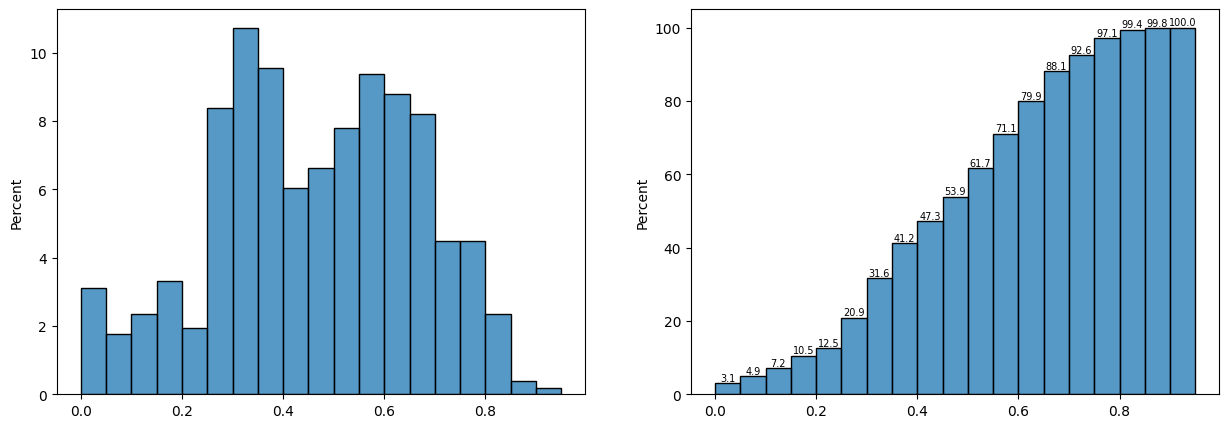

In [371]:
scores = 1-calc_anchor_scores(loss, bboxes_batches, anchors, output_proposals=1)
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(scores, binwidth=0.05, cumulative=False, stat='percent', ax=ax[0])
sns.histplot(scores, binwidth=0.05, cumulative=True, stat='percent', ax=ax[1])
for i in ax[1].containers:
    ax[1].bar_label(i,fmt='%.1f', fontsize=7)

In [36]:
#target_batch = {key: value[:,:1] for key, value in bboxes_batches[1].items()}
target_batch = bboxes_batches[0]
loss_value, y_true_match, y_pred_match = loss(target_batch, {'class': tf.ones((cfg.ds_batch_size, anchors.shape[1])), 'bbox': tf.repeat(anchors, cfg.ds_batch_size, axis=0)})
print(1-loss_value), IoUMetric()(y_true_match['bbox'], y_pred_match['bbox'], y_true_match['class'])

tf.Tensor(
[0.78159845 0.735433   0.82287157 0.7007296  0.77033997 0.69513345
 0.7756606  0.76857567 0.6302373  0.6384512  0.7899844  0.53487056
 0.7283137  0.78763705 0.755238   0.7494787 ], shape=(16,), dtype=float32)


(None, <tf.Tensor: shape=(), dtype=float32, numpy=0.6928629>)

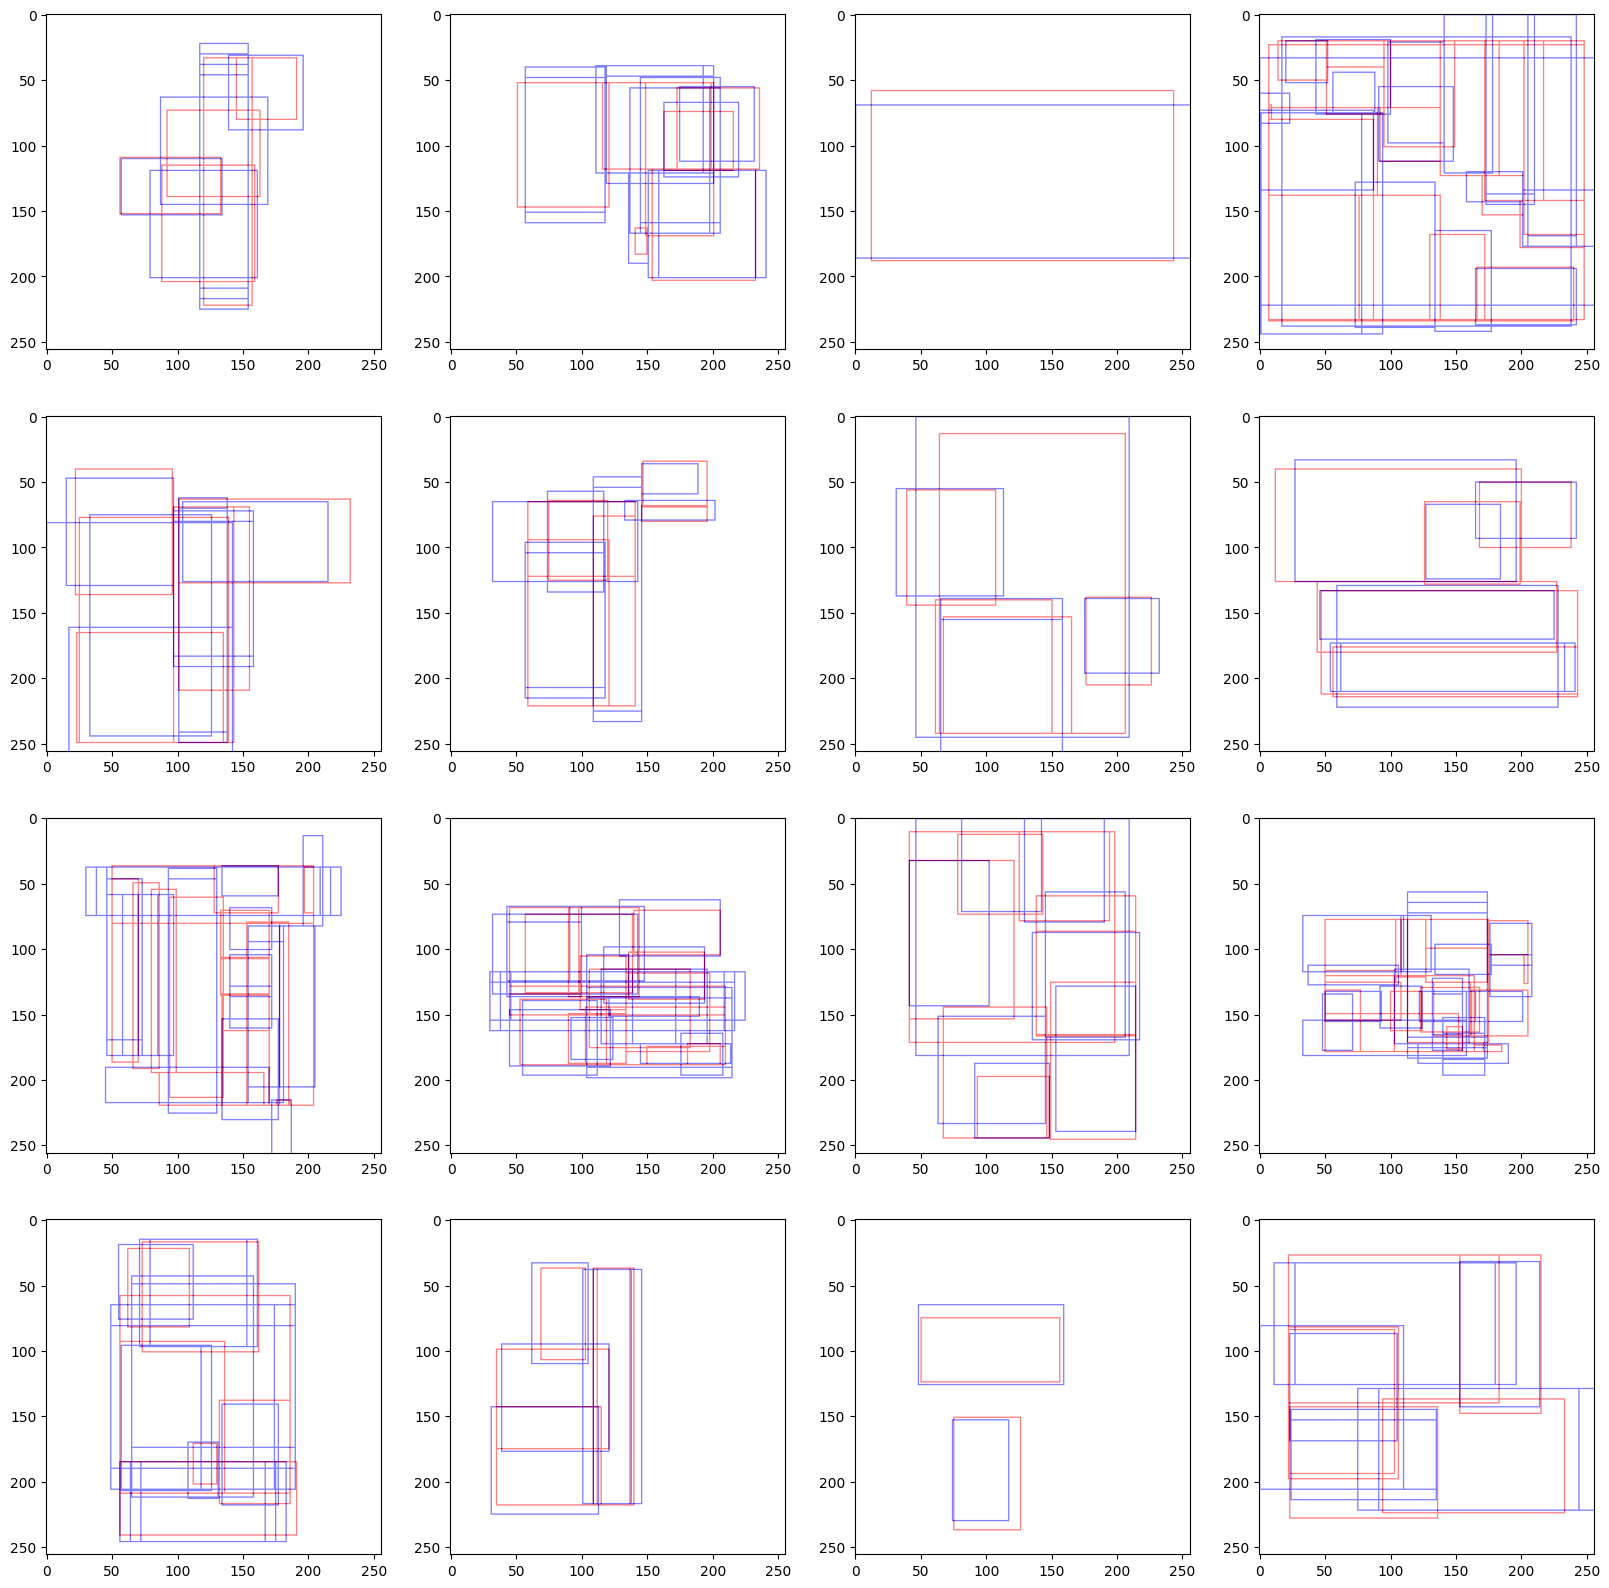

In [37]:
plot_bbox_preds(tf.ones((cfg.ds_batch_size,)+(cfg.target_size,)*2+(3,)), y_true_match, y_pred_match, draw_preds=False, plotsize=5, cols=4)

### Bayesian optimization

In [9]:
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical, Space
from skopt.utils import use_named_args
np.int = int

In [28]:
class AnchorOptimizer:
    def __init__(self,
                 anchor_generator,
                 bboxes_batches,
                 loss,
                 window_sizes=[1,1,1,1,1],
                 max_anchor_size=cfg.target_size
                 ):
        
        self.anchor_generator = anchor_generator
        self.inputs_num = len(anchor_generator.input_sizes)
        self.bboxes_batches = bboxes_batches
        self.loss = loss
        self.max_anchor_size = max_anchor_size
        self.window_sizes = window_sizes

    def _get_parameters(self, params):
        anchor_additions = params[:self.inputs_num]
        anchor_sizes = [min(self.max_anchor_size,sum(anchor_additions[:i+1])) for i in range(len(anchor_additions))]
        anchor_scales = [1.0]+[scale for base_scale in params[self.inputs_num:] for scale in [base_scale, 1/base_scale]]
        anchor_scales.sort()
        window_sizes = self.window_sizes
        return anchor_sizes, anchor_scales, window_sizes

    def _optimize_func(self, params):
        anchor_sizes, anchor_scales, window_sizes = self._get_parameters(params)

        anchors = self.anchor_generator(anchor_sizes, anchor_scales, window_sizes)

        print(f'anchor_sizes: {anchor_sizes} | anchor_scales: {[round(scale, 2) for scale in anchor_scales]}')
        
        score = np.mean(calc_anchor_scores(self.loss, self.bboxes_batches, anchors))

        return score
    
    def run_experiment(self, search_space, optimizer_args):
        result = gp_minimize(self._optimize_func, search_space, **optimizer_args)

        best_score = result.fun
        anchor_sizes, anchor_scales, window_sizes = self._get_parameters(result.x)
        anchor_scales = [round(scale, 2) for scale in anchor_scales]

        print('Best score: %.3f' % (1-best_score))
        print(f'anchor_sizes: {anchor_sizes} | anchor_scales: {anchor_scales}')

        plt.figure(figsize=(6,4))
        sns.histplot(1-result.func_vals, binwidth=0.01, cumulative=False, stat='percent')

        return result


In [29]:
opt = AnchorOptimizer(
    anchor_generator=AnchorGenerator(input_sizes=[64,64,32,16,8,4]),
    bboxes_batches=bboxes_batches,
    loss=loss,
    window_sizes=[3,3,1,1,1,1]
)

anchor_sizes: [19, 29, 71, 75, 89, 154] | anchor_scales: [0.35, 0.75, 1.0, 1.33, 2.84]
32/32 [==============================] - 13s 413ms/step - score: 0.6236
anchor_sizes: [28, 45, 81, 103, 181, 256] | anchor_scales: [0.46, 0.65, 1.0, 1.54, 2.17]
32/32 [==============================] - 13s 411ms/step - score: 0.6697
anchor_sizes: [16, 34, 68, 102, 133, 217] | anchor_scales: [0.5, 0.71, 1.0, 1.4, 2.02]
32/32 [==============================] - 13s 409ms/step - score: 0.6741
anchor_sizes: [7, 13, 70, 90, 136, 223] | anchor_scales: [0.47, 0.59, 1.0, 1.69, 2.12]
32/32 [==============================] - 13s 409ms/step - score: 0.6178
anchor_sizes: [23, 27, 55, 113, 135, 176] | anchor_scales: [0.27, 0.54, 1.0, 1.86, 3.69]
32/32 [==============================] - 13s 416ms/step - score: 0.6365
anchor_sizes: [14, 25, 42, 98, 108, 156] | anchor_scales: [0.21, 0.78, 1.0, 1.28, 4.67]
32/32 [==============================] - 14s 426ms/step - score: 0.5965
anchor_sizes: [7, 32, 86, 98, 117, 148] |

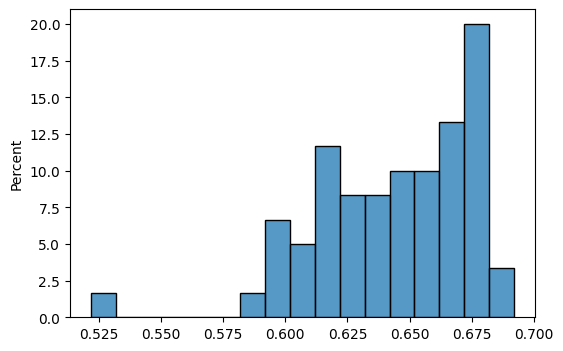

In [34]:
search_space = [
    Integer(2, 32, name='size0'),
    Integer(2, 32, name='size1'),
    Integer(2, 64, name='size2'),
    Integer(4, 64, name='size3'),
    Integer(8, 96, name='size4'),
    Integer(16, 96, name='size5'),
    Real(0.2,0.5, name='scale1'),
    Real(0.5,0.8, name='scale2'),
]

optimizer_args = {
    'n_calls': 60,
    'n_random_starts': 10,
    'n_initial_points': 15
}

result = opt.run_experiment(search_space, optimizer_args)

### scores on BBox sizes

In [18]:
def extract_coords(bbox):
    return bbox[...,0], bbox[...,1], bbox[...,2], bbox[...,3]

def calc_area(Y1,X1,Y2,X2):
    return (X2-X1)*(Y2-Y1)

def calc_bbox_size(Y1,X1,Y2,X2):
    return ((X2-X1)+(Y2-Y1))/2

def IoU(a,b):
    aY1, aX1, aY2, aX2 = extract_coords(a)
    bY1, bX1, bY2, bX2 = extract_coords(b)

    xI = tf.clip_by_value(bX2, aX1, aX2) - tf.clip_by_value(bX1, aX1, aX2)
    yI = tf.clip_by_value(bY2, aY1, aY2) - tf.clip_by_value(bY1, aY1, aY2)

    I = xI*yI
    U = calc_area(aY1, aX1, aY2, aX2)+calc_area(bY1, bX1, bY2, bX2)-I

    return tf.math.divide_no_nan(I,U)

def calc_single_batch_bboxwise_scores(target_batch, anchors, score_func=IoU, img_size=cfg.target_size):
    bbox_nums = tf.cast(tf.reduce_sum(target_batch['class'], axis=1), tf.int32)
    flat_bboxes = tf.concat([example[:n] for n, example in zip(bbox_nums, target_batch['bbox'])], axis=0)
    bbox_sizes = calc_bbox_size(*extract_coords(flat_bboxes))*img_size

    anchors_batch = tf.repeat(anchors, len(flat_bboxes), axis=0)
    flat_bboxes = tf.repeat(flat_bboxes[:,tf.newaxis], anchors.shape[1], axis=1)

    scores = tf.reduce_max(score_func(anchors_batch, flat_bboxes), axis=-1)

    return scores, bbox_sizes


def calc_batch_bboxwise_scores(bboxes_batches, anchors, bin_size=5, score_func=IoU, img_size=cfg.target_size):
    scores = []
    bbox_sizes = []
    for target_batch in bboxes_batches:
        outputs = calc_single_batch_bboxwise_scores(target_batch, anchors, score_func, img_size)
        scores.append(outputs[0])
        bbox_sizes.append(outputs[1])

    scores = tf.concat(scores, axis=0)
    bbox_sizes = tf.concat(bbox_sizes, axis=0)

    print('Overall score: {:.3f}'.format(np.mean(scores)))

    size_limit = int(max(bbox_sizes))+bin_size
    scores_df = pd.DataFrame({'scores': scores.numpy(), 'sizes': bbox_sizes.numpy()})
    agg_scores_df = scores_df.groupby(pd.cut(scores_df.sizes, bins=np.arange(0,size_limit,bin_size))).scores.agg(avg_score='mean', count='count').reset_index()

    s = np.sum(agg_scores_df['avg_score']*agg_scores_df['count'])
    n = np.sum(agg_scores_df['count'])
    m = s/n
    agg_scores_df['score_impact'] = m-(s-agg_scores_df['count']*agg_scores_df['avg_score'])/(n-agg_scores_df['count'])

    fig, ax = plt.subplots(1,4, figsize=(20,4))

    ax[0].set_title('score & size distribution')
    ax[0].set_ylim(0.0,1.0)
    sns.regplot(scores_df, x='sizes', y='scores', order=3, color='indianred', scatter_kws={'color': 'dodgerblue', 'alpha': 0.4, 's': 5}, ax=ax[0])

    ax[1].tick_params('x', labelrotation=90, labelsize=7)
    ax[1].set_title('average score for size')
    sns.barplot(agg_scores_df, x='sizes', y='avg_score', color='mediumseagreen', ax=ax[1])

    ax[2].tick_params('x', labelrotation=90, labelsize=7)
    ax[2].set_title('sizes count')
    sns.barplot(agg_scores_df, x='sizes', y='count', color='slategray', ax=ax[2])

    ax[3].tick_params('x', labelrotation=90, labelsize=7)
    ax[3].set_title('overall impact on final score')
    sns.barplot(agg_scores_df, x='sizes', y='score_impact', color='coral', ax=ax[3])

    return scores, bbox_sizes

(1, 11640, 4)
Overall score: 0.673


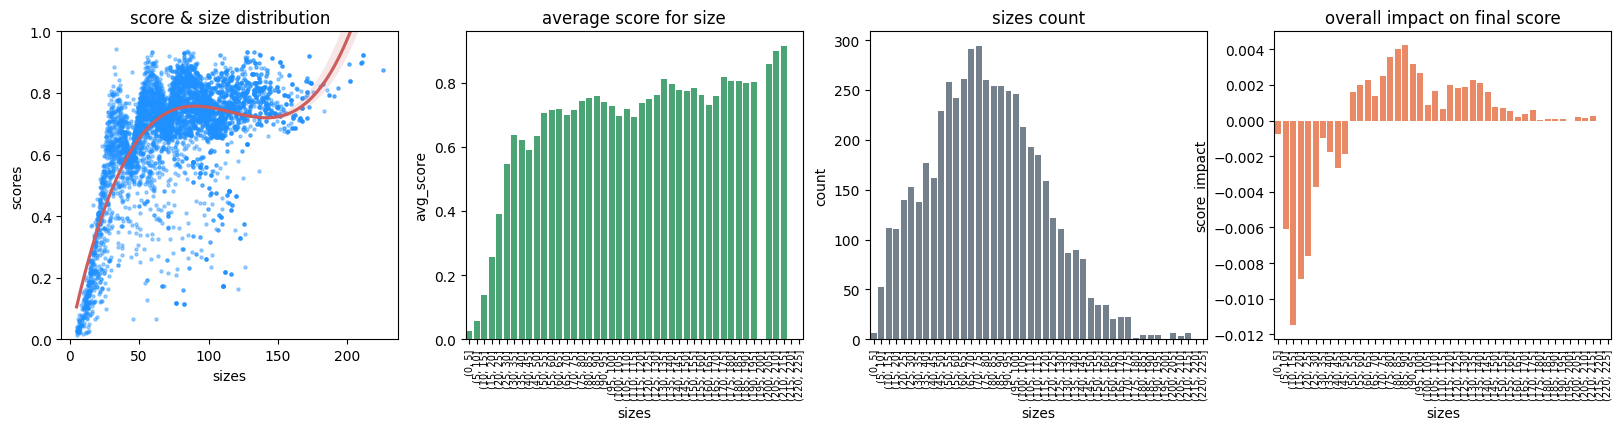

In [35]:
anchors = AnchorGenerator( 
                input_sizes=[64,64,32,16,8,4]
                 )(
                anchor_sizes=[32, 57, 82, 125, 221, 256], 
                anchor_scales=[0.46, 0.74, 1.0, 1.35, 2.18], 
                window_sizes=[3,3,1,1,1,1]
                )
print(anchors.shape)

scores, bbox_sizes = calc_batch_bboxwise_scores(bboxes_batches, anchors)

(1, 6984, 4)
Overall score: 0.636


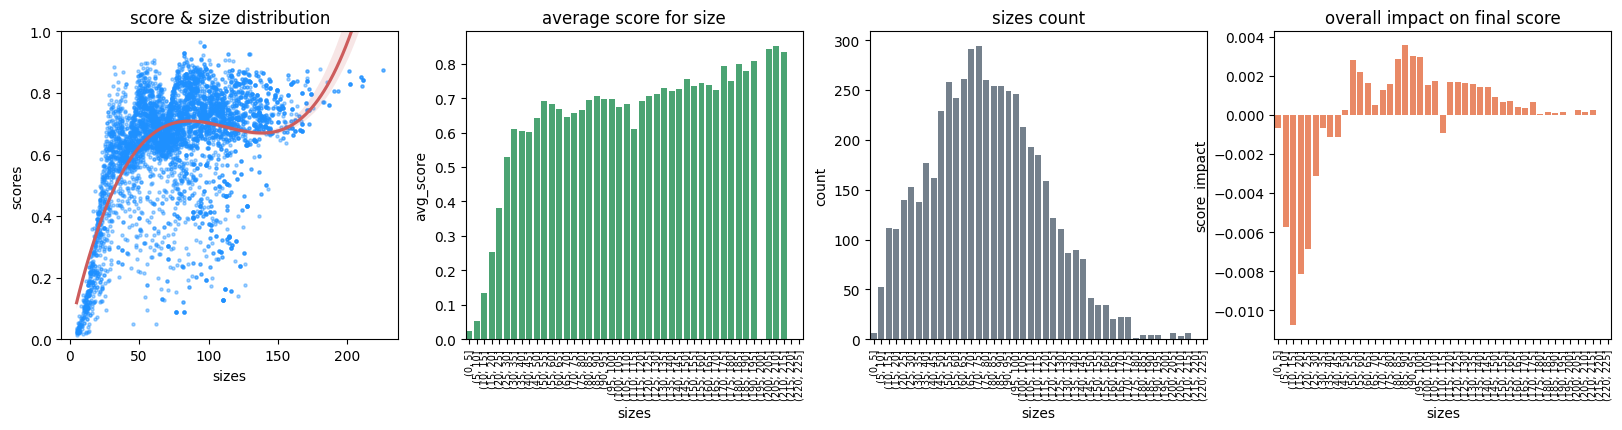

In [31]:
anchors = AnchorGenerator( 
                input_sizes=[64,64,32,16,8,4]
                 )(
                anchor_sizes=[32, 53, 83, 117, 213, 229], 
                anchor_scales=[0.59, 1.0, 1.69], 
                window_sizes=[3,3,1,1,1,1]
                )
print(anchors.shape)

scores, bbox_sizes = calc_batch_bboxwise_scores(bboxes_batches, anchors)

(1, 28656, 4)
Overall score: 0.494


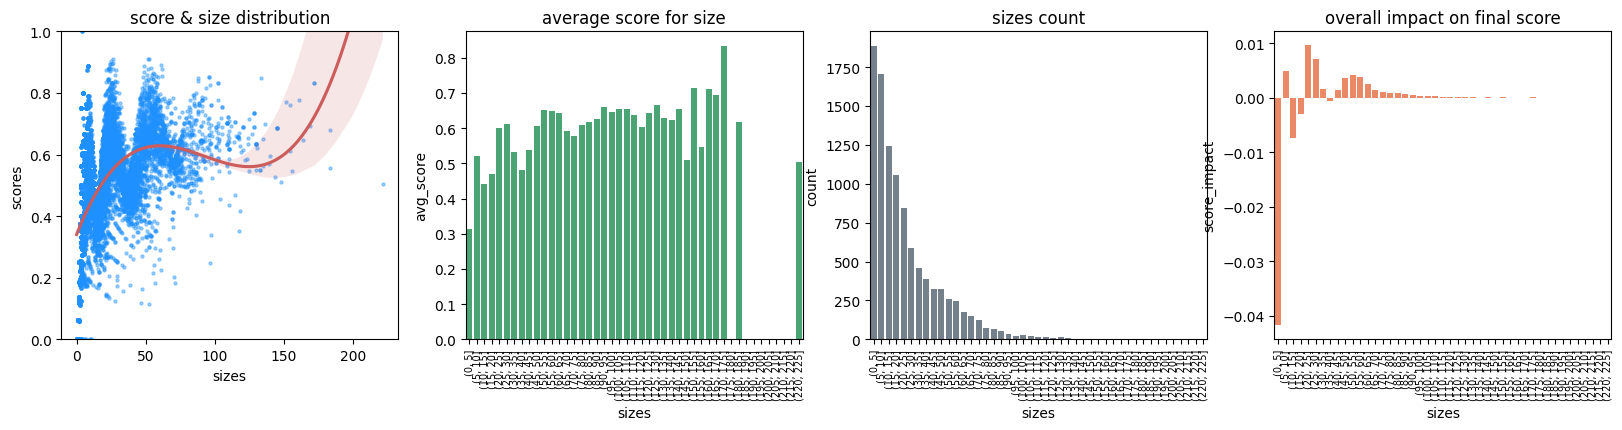

In [13]:
anchors = AnchorGenerator( 
                input_sizes=[64,64,32,16,8,4]
                 )(
                anchor_sizes=[4,8, 23, 52, 93, 157], 
                anchor_scales=[0.61, 1.0, 1.64], 
                window_sizes=[1,1,1,1,1,1]
                )
print(anchors.shape)

scores, bbox_sizes = calc_batch_bboxwise_scores(bboxes_batches, anchors)

Overall score: 0.469


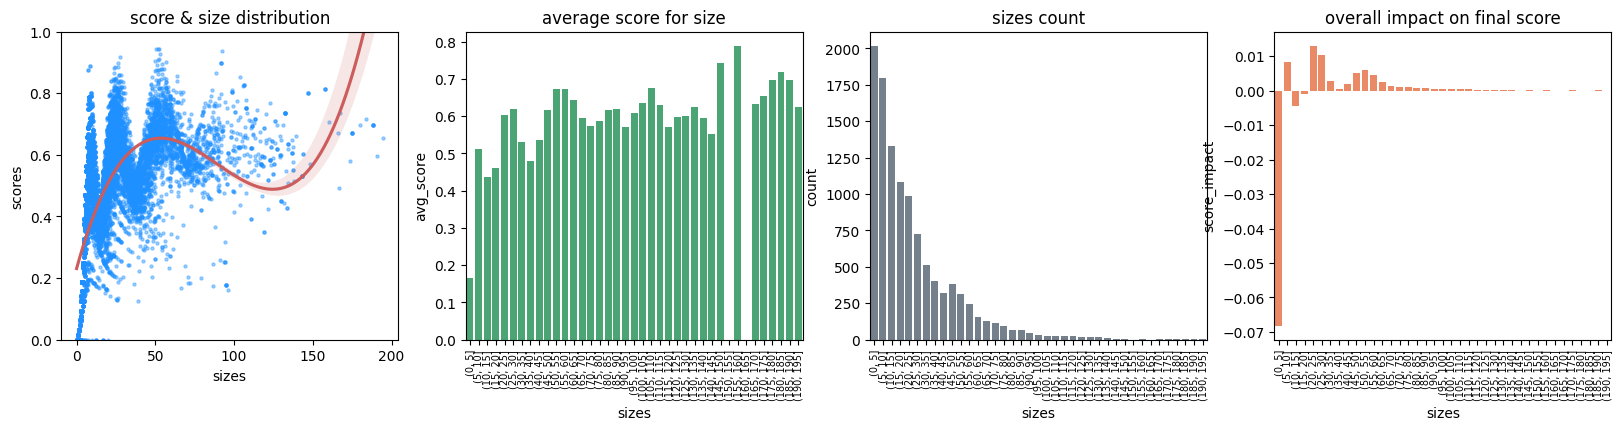

In [365]:
anchors = AnchorGenerator( 
                input_sizes=[64,32,16,8,4]
                 )(
                anchor_sizes=[8, 23, 52, 93, 157], 
                anchor_scales=[0.61, 1.0, 1.64], 
                window_sizes=[1,1,1,1,1]
                )
print(anchors.shape)

scores, bbox_sizes = calc_batch_bboxwise_scores(bboxes_batches, anchors)

### RPN loss function

In [119]:
reload_script('models_src.Mask_RCNN')
reload_script('models_src.Metrics')

In [4]:
from models_src.Mask_RCNN import ResNet4Classification, FeaturePyramid, CombinedMetricsModel, MaskRCNNGenerator
from models_src.Metrics import RPNloss, IoUMetric, IoU

In [5]:
dg = DatasetGenerator(cfg, None)
dg.new_dataset(from_saved=True, batch=True)


Generate new dataset


#### loss method test

In [75]:
features, labels = next(dg.ds_iter)

In [8]:
anchor_args = {
    'input_sizes': [64,64,32,16,8,4],
    'anchor_sizes': [32, 57, 82, 125, 221, 256], 
    'anchor_scales': [0.46, 0.74, 1.0, 1.35, 2.18], 
    'window_sizes': [3,3,1,1,1,1],
    'base_img_size': (256,256)
    }

loss = RPNloss(
    confidence_score=True,
    anchor_args=anchor_args,
    init_top_k_proposals=0.2,
    iou_threshold=0.5,
    output_proposals=50,
    return_matching=True,
    label_proposals=30,
    matching_iou_weight=0.5
)

anchors = loss.anchors

In [76]:
target_bboxes = labels['bbox']
B, T, P = tf.shape(target_bboxes)[0], tf.shape(target_bboxes)[1], tf.shape(anchors)[1]
target_bboxes = tf.repeat(tf.expand_dims(target_bboxes, axis=1), P, axis=1) # [B,P,T,4]
pred_bboxes = tf.repeat(tf.repeat(tf.expand_dims(anchors, 2), T, axis=2), B, axis=0) # [B,P,T,4]

scores = IoU(target_bboxes, pred_bboxes) # [B,P,T]
print(scores.shape)

(16, 11640, 30)


In [77]:
# order of best scores for every proposal
Pscores = tf.reduce_max(scores, axis=2)
Psorted_scores, Porder = tf.math.top_k(Pscores, k=tf.shape(Pscores)[1], sorted=False)

In [78]:
# best scores for every target
Ttop_scores = tf.argmax(scores, axis=1)
Tscores = tf.reduce_max(scores, axis=1)

In [79]:
# best possible score
batch_best_scores = tf.reduce_sum(Tscores, axis=1)/tf.reduce_sum(labels['class'], axis=1)
batch_best_score = tf.reduce_mean(batch_best_scores)
print(f'Batch best score: {batch_best_score}')

Batch best score: 0.7008768320083618


In [81]:
# best score for N best IoUs
N = 50
sim_scores = tf.reduce_max(tf.gather(scores, Porder[:,:N], axis=1, batch_dims=1), axis=1)
sim_scores = tf.reduce_sum(sim_scores, axis=1)/tf.reduce_sum(labels['class'], axis=1)
sim_score = tf.reduce_mean(sim_scores)
print(f'Best simulation score: {sim_score}')

Best simulation score: 0.6506857872009277


In [74]:
bbox_num = tf.cast(tf.reduce_sum(labels['class'], axis=1), tf.int32)
for idxs, n, example_scores, scores_order in zip(Ttop_scores, bbox_num, Pscores, Porder):
    scores_order = tf.sparse.to_dense(tf.sparse.reorder(tf.SparseTensor(tf.cast(scores_order, tf.int64)[:,tf.newaxis], tf.range(0,len(scores_order)), (len(example_scores),))))
    print(tf.gather(scores_order, idxs[:n]))
    print(tf.gather(example_scores, idxs[:n]))

tf.Tensor([ 4 11  9  4  0  1  9], shape=(7,), dtype=int32)
tf.Tensor(
[0.76057065 0.6901458  0.694426   0.76057065 0.84015167 0.8321736
 0.694426  ], shape=(7,), dtype=float32)
tf.Tensor([ 1 66  8 50 15  5  1  8  1  1  8 15  0], shape=(13,), dtype=int32)
tf.Tensor(
[0.8481939  0.66945183 0.77293885 0.69023377 0.74799824 0.801505
 0.8481939  0.77293885 0.8481939  0.8481939  0.77293885 0.74799824
 0.85076076], shape=(13,), dtype=float32)
tf.Tensor([ 0 20  6 27 30 13 67  4], shape=(8,), dtype=int32)
tf.Tensor(
[0.904869   0.69996864 0.85481834 0.6881306  0.6642785  0.80381244
 0.58181816 0.8856383 ], shape=(8,), dtype=float32)
tf.Tensor([   0    9 1440  181  255    8], shape=(6,), dtype=int32)
tf.Tensor([0.84140784 0.6860918  0.2099609  0.42382827 0.3898635  0.68817216], shape=(6,), dtype=float32)
tf.Tensor(
[   1   19    2    5    8 1978 1273   25    9   40   36   13   10   31
   42    0    4 1075], shape=(18,), dtype=int32)
tf.Tensor(
[0.83930373 0.74882    0.8392696  0.820897   0.80009

#### model fit test

In [121]:
MaskRCNN = MaskRCNNGenerator()

In [122]:
model = MaskRCNN(model_type='RPN', 
                 backbone_training=False,
                 backbone_pretrained=True,
                 backbone_args={'config_args': {'hidden_sizes': [256,512,1024,2048]}, 'FN_filters': [512,512], 'output_hidden_states': True},
                 RPN_training=True,
                 RPN_pyramid_args={'out_indices': [1,2,3,4], 'add_maxpool': True, 'output_dim': 256},
                 RPN_rpn_args={'anchor_sizes': [32, 57, 82, 125, 221, 256], 'anchor_scales': [0.46, 0.74, 1.0, 1.35, 2.18], 'window_sizes': [3,3,1,1,1,1], 'input_mapping': [0,0,1,2,3,4], 
                               'init_top_k_proposals': 0.3, 'output_proposals': 200, 'normalize_bboxes': True, 'bbox_training': False},
                 Head_training=False,
                 CombinedModel_metrics=[
                {'metric': tf.keras.metrics.BinaryAccuracy(name='ACC'), 'label': 'class', 'weight_label': None},
                #{'metric': WeightedF12D(name='F1'), 'label': 'mask', 'weight_label': 'class'},
                #{'metric': tf.keras.metrics.Precision(name='Prec'), 'label': 'mask', 'weight_label': 'class'},
                #{'metric': tf.keras.metrics.Recall(name='Rec'), 'label': 'mask', 'weight_label': 'class'},
                {'metric': tf.keras.metrics.MeanAbsoluteError(name='MAE'), 'label': 'bbox', 'weight_label': 'class'},
                {'metric': IoUMetric(name='IoU'), 'label': 'bbox', 'weight_label': 'class'},
            ])
model.summary(expand_nested=False)

windows nums: [484, 484, 1024, 256, 64, 16]
all anchors num: 11640
top k anchors num: 3492
Model: "combined_metrics_model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 ResNet (Functional)         ((None, 64, 64, 64),         2356115   ['input_26[0][0]']            
                              (None, 256, 64, 64),        2                                       
                              (None, 512, 32, 32),                                                
                              (None, 1024, 16, 16),                                               
                              (None, 2048, 8, 8))                                  

In [89]:
anchor_args = {
    'input_sizes': [64,64,32,16,8,4],
    'anchor_sizes': [32, 57, 82, 125, 221, 256], 
    'anchor_scales': [0.46, 0.74, 1.0, 1.35, 2.18], 
    'window_sizes': [3,3,1,1,1,1],
    'base_img_size': (256,256)
    }

In [123]:
loss = RPNloss(
    confidence_score=True,
    anchor_args=anchor_args,
    init_top_k_proposals=0.2,
    iou_threshold=0.5,
    output_proposals=50,
    return_matching=True,
    label_proposals=30,
    matching_iou_weight=0.5
)

In [124]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss,
              metrics=[])

In [ ]:
model.fit(dg.ds, epochs=5, steps_per_epoch=512//cfg.ds_batch_size)

In [125]:
model.evaluate(dg.ds, steps=3)

3/3 [==============================] - 6s 1s/step - loss: 1.4670 - ACC: 1.0000 - MAE: 0.1501 - IoU: 0.1437


[1.4669939279556274, 1.0, 0.1500730812549591, 0.14374111592769623]

In [97]:
features, labels = next(dg.ds_iter)
preds = model(features, training=False)

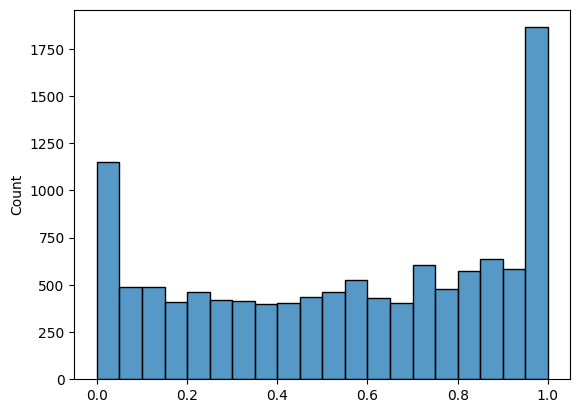

In [93]:
%matplotlib inline
sns.histplot(preds['class'][0].numpy(), binwidth=0.05)
plt.show()

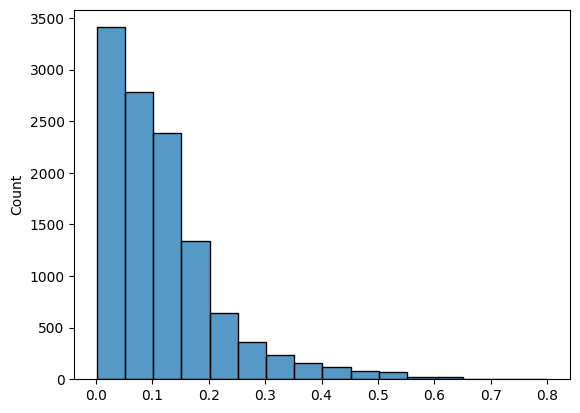

In [99]:
%matplotlib inline
sns.histplot(preds['class'][0].numpy(), binwidth=0.05)
plt.show()

# Input BBox size distribution control

In [530]:
from src.map_drawing import map_drawer_input_generator
import json
from scipy.stats import skewnorm, uniform, describe, gamma
from operator import pow, mul

with open(full_map_gen_args['parcel_input_args_path'], "r") as f:
    input_generator_args = json.loads(f.read())

In [500]:
reload_script('src.map_drawing')

In [11]:
def bbox_size_from_input_shape(shape):
    # shape input [N,1,2]
    XY1 = np.min(shape, axis=0)[0]
    XY2 = np.max(shape, axis=0)[0]
    sizes = XY2-XY1
    return np.mean(sizes)


def relative_input_bbox_sizes(shapes, img_size):
    img_size = np.mean(img_size)

    return np.array([bbox_size_from_input_shape(shape) for shape in shapes])/img_size

def random_shapes_num(patterns_range=(1,20), multishape_prob=0.5, multishape_range=(2,6)):
    patterns_num = np.random.randint(*patterns_range)
    multishapes = np.random.binomial(patterns_num, multishape_prob)
    multishapes_size = np.sum(np.random.randint(*multishape_range, multishapes))

    return multishapes_size+patterns_num-multishapes

def input_distribution_simulation(shapes, img_size, distr_func, distr_args, patterns_range=(1,20), multishape_prob=0.5, multishape_range=(2,6), minimal_size=5/256):
    shapes_num = len(shapes)
    target_shapes_num = min(shapes_num, random_shapes_num(patterns_range, multishape_prob, multishape_range))

    ## filter out small shapes
    max_shapes_to_delete = max(0, shapes_num-target_shapes_num)
    bbox_sizes = relative_input_bbox_sizes(shapes, img_size)

    small_bbox_idxs = np.where(bbox_sizes<minimal_size)[0]
    if (max_shapes_to_delete>0) & (len(small_bbox_idxs)>0):
        idxs_to_delete = np.random.choice(small_bbox_idxs, size=min(max_shapes_to_delete, len(small_bbox_idxs)), replace=False)
        bbox_sizes = np.delete(bbox_sizes, idxs_to_delete, axis=0)
        shapes_num = len(bbox_sizes)
    #######

    probs = distr_func.pdf(bbox_sizes, **distr_args)+1e-5
    probs = probs/np.sum(probs)

    bbox_idxs = np.random.choice(list(range(shapes_num)), size=target_shapes_num, replace=False, p=probs)

    return bbox_sizes[bbox_idxs]

### patterns num distribution

<Axes: ylabel='Percent'>

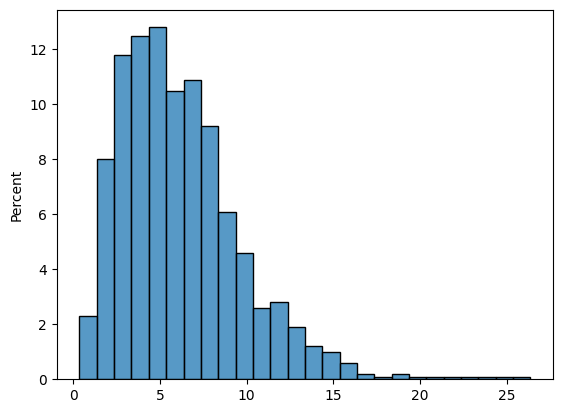

In [538]:
patterns_dist = gamma.rvs(a=3.0, loc=0.0, scale=2.0, size=1000)
sns.histplot(patterns_dist, binwidth=1, cumulative=False, stat='percent')

### target BBox size distribution

In [502]:
ig = map_drawer_input_generator(client, **input_generator_args, batch_size=128, test_mode=1, adjustment=True)

Parcels memory usage: 2.029 MB


In [503]:
parcels_example, background_example = next(ig)
shapes, img_size, padding = parcels_example.values()

In [504]:
# INITIAL BBOX SIZE DISTRIBUTION
initial_bbox_dist = np.concatenate([input_distribution_simulation(*list(next(ig)[0].values())[:2], distr_func=uniform, distr_args={'loc': 0.0, 'scale': 1.0}, minimal_size=0) 
                             for _ in range(128)], axis=0)
distr_description = describe(initial_bbox_dist)
print('Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format(distr_description.mean, distr_description.variance**0.5, distr_description.skewness))

Mean: 0.17 | Std: 0.11 | Skew: 1.35


In [505]:
# BEST FIT BBOX SIZE DISTRIBUTION
best_fit_dist = np.concatenate([input_distribution_simulation(*list(next(ig)[0].values())[:2], distr_func=skewnorm, distr_args={'a': 15.0, 'loc': 0.31, 'scale': 0.8}, minimal_size=5/cfg.target_size) 
                             for _ in range(128)], axis=0)
distr_description = describe(best_fit_dist)
print('Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format(distr_description.mean, distr_description.variance**0.5, distr_description.skewness))

Mean: 0.20 | Std: 0.12 | Skew: 1.22


Mean: 0.31 | Std: 0.18 | Skew: 0.74


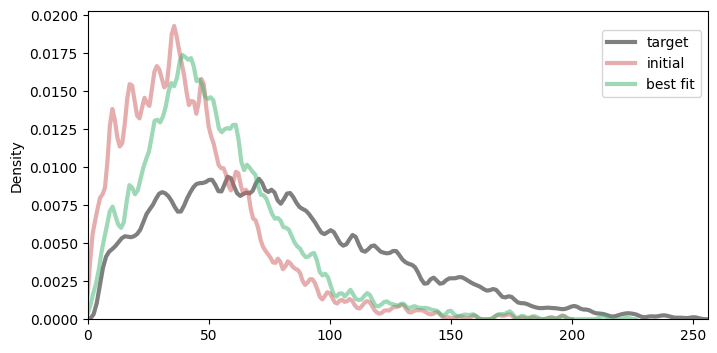

In [525]:
# COMPARISION TO TARGET DISTRIBUTION
fig = plt.figure(figsize=(8,4))
plt.xlim(0, cfg.target_size)

target_distr_sim = skewnorm.rvs(a=3.0, loc=0.07, scale=0.3, size=5000)
target_distr_sim = np.delete(target_distr_sim, np.where((target_distr_sim<5/256) | (target_distr_sim>1)))
distr_description = describe(target_distr_sim)
print('Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format(distr_description.mean, distr_description.variance**0.5, distr_description.skewness))
#sns.histplot(target_distr_sim*cfg.target_size, color='black', binwidth=5, stat='probability', alpha=0.5, fill=False, element='step')
#sns.histplot(initial_bbox_dist*cfg.target_size, color='indianred', binwidth=5, stat='probability', alpha=0.3, fill=False, element='step')
#sns.histplot(best_fit_dist*cfg.target_size, color='mediumseagreen', binwidth=5, stat='probability', alpha=0.3, fill=False, element='step')
bw_adjust=0.2
sns.kdeplot(target_distr_sim*cfg.target_size, color='black', bw_adjust=bw_adjust, alpha=0.5, linewidth=3)
sns.kdeplot(initial_bbox_dist*cfg.target_size, color='indianred', bw_adjust=bw_adjust, alpha=0.5, linewidth=3)
sns.kdeplot(best_fit_dist*cfg.target_size, color='mediumseagreen', bw_adjust=bw_adjust, alpha=0.5, linewidth=3)
fig.legend(labels=['target', 'initial', 'best fit'], loc='upper right', bbox_to_anchor=(0.4,0.4,0.5,0.45))

### Shape probability optimization

In [465]:
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical, Space
from skopt.utils import use_named_args
np.int = int

In [6]:
input_generator_args

{'radius_range': [200, 400],
 'target_map_size_range': [1500, 3000],
 'padding_range': [50, 400]}

In [539]:
custom_ig_args = {
    'randomize_args': {
    'radius_range': [200, 400],
    'target_map_size_range': [1500, 3000],
    'padding_range': [50, 400]
},
    'adjustment_args': {
        'target_mean_size': 0.31,
        'min_shapes_num': 20,
        'adjust_extending': True
    }}

ig = map_drawer_input_generator(client, **custom_ig_args, batch_size=512, test_mode=1, adjustment=True)

Parcels memory usage: 6.105 MB


Average available parcels: 37.30859375


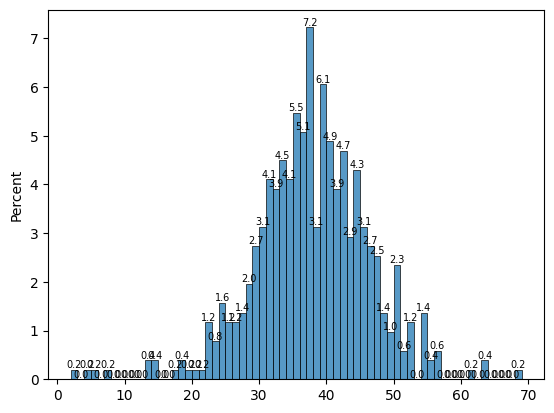

In [540]:
# TEST NUMBER OF AVAILABLE PARCELS
parcel_spaces = [len(next(ig)[0]['shapes']) for _ in range(512)]
print(f'Average available parcels: {np.mean(parcel_spaces)}')
ax = sns.histplot(parcel_spaces, binwidth=1, cumulative=False, stat='percent')
for i in ax.containers:
    ax.bar_label(i,fmt='%.1f', fontsize=7)

In [522]:
class DistOptimizer:
    def __init__(self,
                 input_generator,
                 target_size=256):
        
        self.target_size = target_size
        self.ig = input_generator
        self.ig_len = input_generator.batch_size

    def _eval_distribution(self, params):
        
        sizes_dist = np.concatenate([input_distribution_simulation(*list(next(self.ig)[0].values())[:2],
                                                                   distr_func=self.distr_func, 
                                                                   distr_args={key: value for key, value in zip(self.distr_keys, params[:len(self.distr_keys)])},
                                                                   patterns_range=(1,params[-1]), 
                                                                   minimal_size=self.minimal_size) 
                             for _ in range(self.ig_len)], axis=0)
        
        distr_description = describe(sizes_dist)
        return sizes_dist, distr_description

    def _optimize_func(self, params):
        sizes_dist, distr_description = self._eval_distribution(params)
        score = np.sum([self._calc_single_score(target_measure, distr_description) for target_measure in self.target_measures])
        self.score_metric = min(self.score_metric, score)
        self.pb.add(1, values=[('best score', self.score_metric)])
        #print('{:.8} Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f} | Score {:.3f}'.format(f'{self.i}/{self.n}',distr_description.mean, distr_description.variance**0.5, distr_description.skewness, score))
        return score

    def _calc_single_score(self, target_measure, distr_description):
        value = target_measure['result_operator'](getattr(distr_description, target_measure['stat']), target_measure['operator_arg'])
        score = np.abs(value-target_measure['target_value'])*target_measure['weight']
        return score

    def run_experiment(self, search_space, optimizer_args, distr_func, distr_keys, minimal_size, target_measures, target_distr_sim, initial_bbox_dist, binwidth=5):

        self.target_measures = target_measures
        self.distr_func = distr_func
        self.distr_keys = distr_keys
        self.minimal_size = minimal_size

        self.pb = tf.keras.utils.Progbar(optimizer_args['n_calls'], stateful_metrics=['best score'])
        self.score_metric = 1.0

        result = gp_minimize(self._optimize_func, search_space, **optimizer_args)

        best_score = result.fun
        print('\nBest score: %.3f' % (best_score))
        best_params = result.x
        print('\nBest distr params: %s' % (str({key: value for key, value in zip(self.distr_keys, best_params)})))
        print(f'Best shapes num range: {best_params[-1]}')

        best_fit_dist, best_fit_distr_description = self._eval_distribution(best_params)
        target_distr_description = describe(target_distr_sim)
        print('\nNormalized:')
        print('{:9s}-> Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format('Target',target_distr_description.mean, target_distr_description.variance**0.5, target_distr_description.skewness))
        print('{:9s}-> Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format('Best fit',best_fit_distr_description.mean, best_fit_distr_description.variance**0.5, best_fit_distr_description.skewness))

        target_distr_description = describe(target_distr_sim*self.target_size)
        best_fit_distr_description = describe(best_fit_dist*self.target_size)
        print('\nScaled:')
        print('{:9s}-> Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format('Target',target_distr_description.mean, target_distr_description.variance**0.5, target_distr_description.skewness))
        print('{:9s}-> Mean: {:.2f} | Std: {:.2f} | Skew: {:.2f}'.format('Best fit',best_fit_distr_description.mean, best_fit_distr_description.variance**0.5, best_fit_distr_description.skewness))


        fig, ax = plt.subplots(1,2, figsize=(14,4))
        ax[0].set_xlim(0, self.target_size)
        ax[1].set_xlim(0, self.target_size)

        ax[0].set_title('Distributions comparision')
        bw_adjust=0.2
        sns.kdeplot(target_distr_sim*self.target_size, color='black', bw_adjust=bw_adjust, alpha=0.5, linewidth=3, ax=ax[0])
        sns.kdeplot(initial_bbox_dist*self.target_size, color='indianred', bw_adjust=bw_adjust, alpha=0.5, linewidth=3, ax=ax[0])
        sns.kdeplot(best_fit_dist*self.target_size, color='mediumseagreen', bw_adjust=bw_adjust, alpha=0.5, linewidth=3, ax=ax[0])
        ax[0].figure.legend(labels=['target', 'initial', 'best fit'], loc='upper right', bbox_to_anchor=(0.4,0.5,0.5,0.45))

        ax[1].set_title('Best fit')
        sns.histplot(best_fit_dist*self.target_size, color='mediumseagreen', binwidth=5, stat='probability', ax=ax[1])

        return result

In [541]:
opt = DistOptimizer(
    input_generator=ig,
    target_size=cfg.target_size
)

150/150 [==============================] - 184s 1s/step - best score: 0.0346

Best score: 0.035

Best distr params: {'a': 13.806692551229444, 'loc': 0.8207050062704002, 'scale': 2.0418223498225174}
Best shapes num range: 10

Normalized:
Target   -> Mean: 0.31 | Std: 0.18 | Skew: 0.74
Best fit -> Mean: 0.25 | Std: 0.14 | Skew: 0.75

Scaled:
Target   -> Mean: 79.29 | Std: 46.86 | Skew: 0.74
Best fit -> Mean: 62.76 | Std: 36.38 | Skew: 0.75


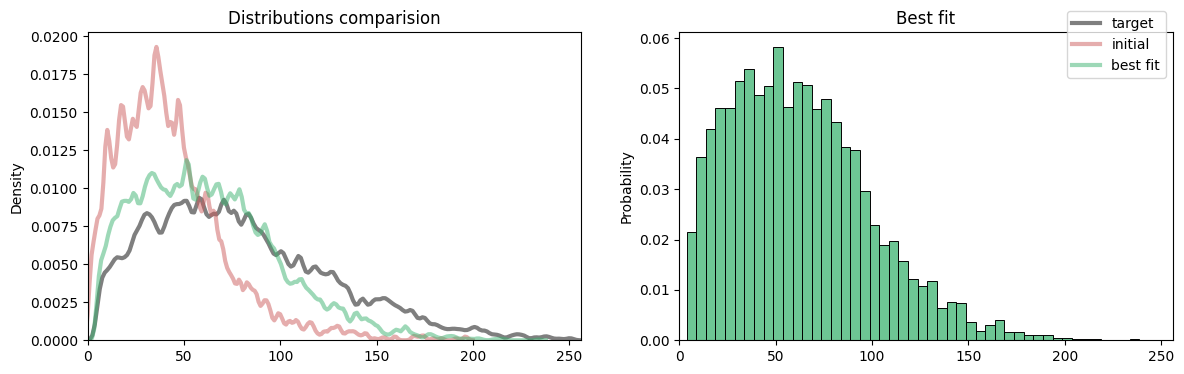

In [544]:
target_measures = [
    {'stat': 'mean', 'target_value': 0.31, 'weight': 0.2, 'result_operator': mul, 'operator_arg': 1},
    {'stat': 'variance', 'target_value': 0.18, 'weight': 0.6, 'result_operator': pow, 'operator_arg': 0.5},
    {'stat': 'skewness', 'target_value': 0.74, 'weight': 0.2, 'result_operator': mul, 'operator_arg': 1}
]

search_space = [
    Real(0.0, 25.0, name='skewness'),
    Real(0.05, 2.0, name='mean'),
    Real(0.05, 3.0, name='std'),
    Integer(10, 20, name='patterns_range')
]

distr_keys = ['a', 'loc', 'scale']

optimizer_args = {
    'n_calls': 150,
    'n_random_starts': 30,
    'n_initial_points': 15
}

result = opt.run_experiment(
    search_space=search_space,
    optimizer_args=optimizer_args,
    distr_func=skewnorm,
    distr_keys=distr_keys,
    minimal_size=5/cfg.target_size,
    target_measures=target_measures,
    target_distr_sim=target_distr_sim,
    initial_bbox_dist=initial_bbox_dist
)

Average shapes number: 11.3293


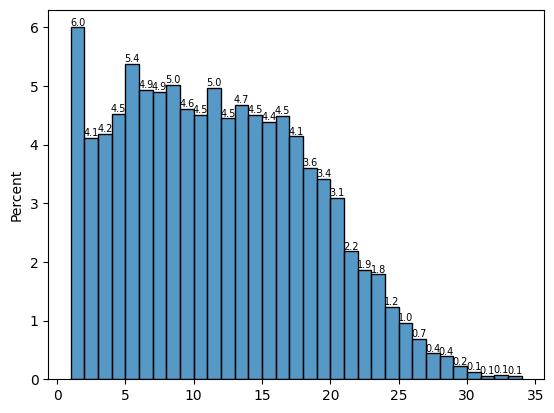

In [277]:
# NUMBER OF SHAPES SIMULATION
shapes_distr = np.array([random_shapes_num(patterns_range=(1,10)) for _ in range(10000)])
print(f'Average shapes number: {np.mean(shapes_distr)}')
ax = sns.histplot(shapes_distr, binwidth=1, cumulative=False, stat='percent')
for i in ax.containers:
    ax.bar_label(i,fmt='%.1f', fontsize=7)

### parcel input adjustment

In [7]:
custom_ig_args = {
    'radius_range': [200, 400],
    'target_map_size_range': [1500, 3000],
    'padding_range': [50, 100]
}
ig = map_drawer_input_generator(client, input_generator_args, batch_size=32, test_mode=1)

Parcels memory usage: 0.184 MB


In [48]:
def bbox_center(shape):
    # input shape [N,1,2]
    # output shape [2]
    XY1 = np.min(shape, axis=0)[0]
    XY2 = np.max(shape, axis=0)[0]
    return XY1+(XY2-XY1)/2

def bbox_from_input_shape(shape):
    # input shape [N,1,2]
    # output shape [Xmin,Ymin,Xmax,Ymax]
    XY1 = np.min(shape, axis=0)[0]
    XY2 = np.max(shape, axis=0)[0]
    return np.concatenate([XY1, XY2], axis=0)

def draw_background_parcels(shapes, img_size, color=(0,0,0), fill=False):
        img = np.ones(img_size[::-1]+[3], np.uint8)*255
        if not fill:
            cv.polylines(img, shapes, True, color=color)
        else:
            cv.fillPoly(img, shapes, color=color)
        return img

In [ ]:
target_mean_size = 0.28

#### scaling window method

In [129]:
shapes, img_size, padding = next(ig)[0].values()

Avg size: 0.13624264933457136 | Shapes num: 35


<Axes: ylabel='Count'>

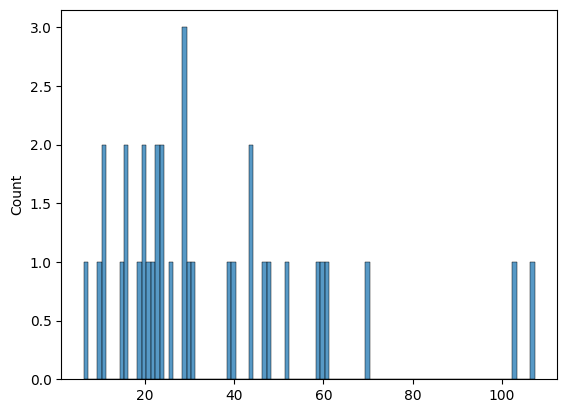

In [153]:
bbox_sizes = relative_input_bbox_sizes(shapes, img_size)
print(f'Avg size: {np.mean(bbox_sizes)} | Shapes num: {len(bbox_sizes)}')
sns.histplot(bbox_sizes*cfg.target_size, binwidth=1)

In [154]:
initial_mean_size = np.mean(bbox_sizes)
approx_window_size = (initial_mean_size/target_mean_size*img_size).astype(np.int32)
print(f'Approx window size: {approx_window_size}')
print(f'Original IMG size: {img_size}')
print(f'Padding {padding}')

Approx window size: [705 866]
Original IMG size: [1450 1781]
Padding 162


In [155]:
centroids = np.stack([bbox_center(shape) for shape in shapes], axis=0)
center = np.mean(centroids, axis=0)

In [156]:
bboxes = np.stack([bbox_from_input_shape(shape) for shape in shapes], axis=0)
higher = np.all(bboxes[:,:2]>(center-approx_window_size/2), axis=-1)
lower = np.all(bboxes[:,2:]<(center+approx_window_size/2), axis=-1)
filtered_idxs = np.where(higher*lower)[0]
filtered_shapes = [shapes[i] for i in filtered_idxs]
filtered_bboxes = bboxes[filtered_idxs]

left_upper = np.min(filtered_bboxes[:,:2], axis=0)
right_bottom = np.max(filtered_bboxes[:,2:], axis=0)
new_window_size = right_bottom-left_upper
print(f'New window size {new_window_size}')

scaler = (img_size-2*padding)/new_window_size
print(f'Scaler: {scaler}')
filtered_bbox_sizes = relative_input_bbox_sizes(filtered_shapes, img_size)
print(f'Avg size: {np.mean(filtered_bbox_sizes)*np.mean(scaler)} | Shapes num: {len(filtered_bbox_sizes)}')

left_upper = left_upper[np.newaxis, np.newaxis]
scaler = scaler[np.newaxis, np.newaxis]

New window size [613 840]
Scaler: [1.83686786 1.73452381]
Avg size: 0.1579451607612078 | Shapes num: 23


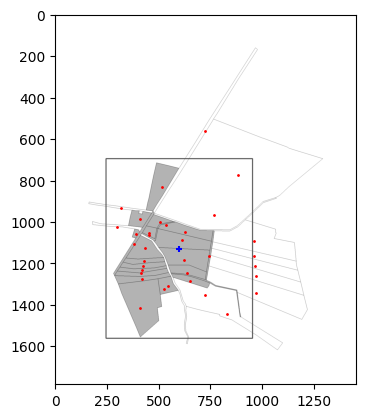

In [157]:
img = draw_background_parcels(shapes, img_size, fill=False)
filtered_img = draw_background_parcels(filtered_shapes, img_size, fill=True)
cv.rectangle(img, (center-approx_window_size/2).astype(np.int32), (center+approx_window_size/2).astype(np.int32), color=(0,255,0), thickness=3)
plt.imshow(img, cmap='gray')
plt.imshow(filtered_img, cmap='gray', alpha=0.3)
plt.scatter(centroids[:,0], centroids[:,1], s=1, marker='o', color='red')
plt.scatter(*center, s=20, marker='+', color='blue')

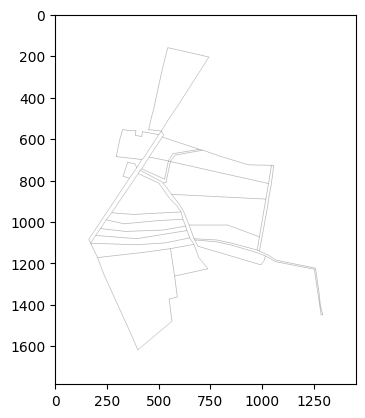

In [158]:
rescaled_shapes = [((shape-left_upper)*scaler).astype(np.int32)+padding for shape in filtered_shapes]

rescaled_img = draw_background_parcels(rescaled_shapes, img_size, fill=False)
plt.imshow(rescaled_img, cmap='gray')

Avg size: 0.1590165919825602 | Shapes num: 23


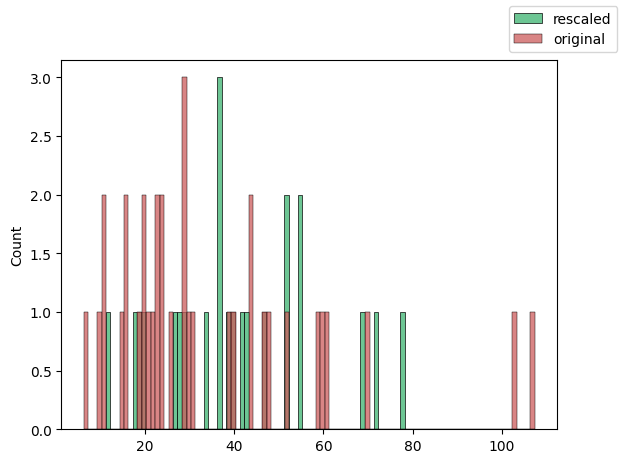

In [159]:
rescaled_bbox_sizes = relative_input_bbox_sizes(rescaled_shapes, img_size)
print(f'Avg size: {np.mean(rescaled_bbox_sizes)} | Shapes num: {len(rescaled_bbox_sizes)}')
fig, ax = plt.subplots(1,1)
sns.histplot(rescaled_bbox_sizes*cfg.target_size, binwidth=1, color='mediumseagreen', ax=ax)
sns.histplot(bbox_sizes*cfg.target_size, binwidth=1, color='indianred', ax=ax)
fig.legend(labels=['rescaled', 'original'])

#### iterative method

In [ ]:
import shapely

In [491]:
def crop_shape_by_window(shape, window_polygon):
    shape_polygon = shapely.Polygon(shape[:,0])
    if shapely.intersects(shape_polygon, window_polygon):
        try:
            shape_polygon = shapely.intersection(shape_polygon, window_polygon)
            coords = np.array([[x,y] for x,y in zip(*shape_polygon.exterior.xy)])[:,np.newaxis]
            if len(coords)>2:
                return coords
            else:
                return None
        except:
            return None
    else:
        return None

def cropping_shape_input(shapes, img_size, padding, target_mean_size, min_shapes_num, adjust_extending=False):
    bbox_sizes = relative_input_bbox_sizes(shapes, img_size)
    centroids = np.stack([bbox_center(shape) for shape in shapes], axis=0)
    bboxes = np.stack([bbox_from_input_shape(shape) for shape in shapes], axis=0)
    init_window_size = img_size-2*padding

    filtered_shapes = shapes.copy()
    approx_mean_size = np.mean(bbox_sizes)
    shapes_num = len(shapes)
    scaler = 1.0
    
    while (shapes_num>min_shapes_num) & (approx_mean_size<target_mean_size):
        center = np.mean(centroids, axis=0, keepdims=True)
        corners = [bboxes[:,[x,y]] for x in [0,2] for y in [1,3]]
        corner_scores = [np.mean(np.abs(corner-center), axis=-1) for corner in corners]
        corner_scores_agg = [np.max(s) for s in corner_scores]
        delete_idx = np.argmax(corner_scores[np.argmax(corner_scores_agg)])

        bbox_sizes = np.delete(bbox_sizes, delete_idx, axis=0)
        bboxes = np.delete(bboxes, delete_idx, axis=0)
        centroids = np.delete(centroids, delete_idx, axis=0)
        filtered_shapes.pop(delete_idx)
        
        new_window_size = np.max(bboxes[:,2:], axis=0)-np.min(bboxes[:,:2], axis=0)
        scaler = init_window_size/new_window_size
        approx_mean_size = np.mean(bbox_sizes)*np.mean(scaler)
        shapes_num -= 1

    left_upper = np.min(bboxes[:,:2], axis=0)

    if adjust_extending:
        right_bottom = np.max(bboxes[:,2:], axis=0)
        window = np.concatenate([left_upper, right_bottom], axis=0)
        window_polygon = shapely.Polygon([window[[x,y]] for x,y in zip([0,0,2,2],[1,3,3,1])])
        filtered_shapes = [shape for shape in [crop_shape_by_window(shape, window_polygon) for shape in shapes] if shape is not None]

    left_upper = left_upper[np.newaxis, np.newaxis]
    rescaled_shapes = [((shape-left_upper)*scaler).astype(np.int32)+padding for shape in filtered_shapes]

    return rescaled_shapes

Initial measures
Avg size: 0.0662568306010929 | Shapes num: 61

Rescaled measures
Avg size: 0.14369114877589453 | Shapes num: 20

Rescaled with adjustment measures
Avg size: 0.18462860771690098 | Shapes num: 43


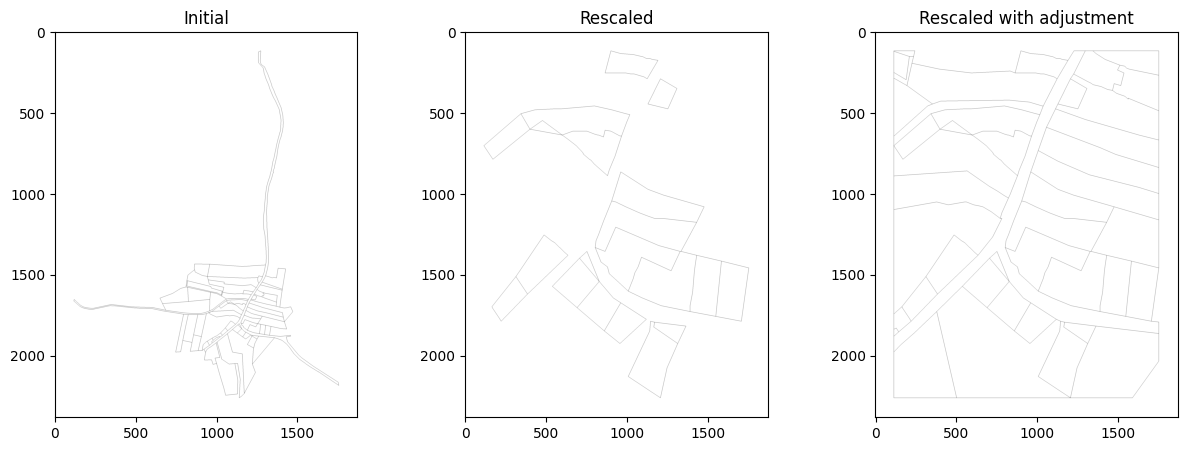

In [464]:
#shapes, img_size, padding = next(ig)[0].values()
bbox_sizes = relative_input_bbox_sizes(shapes, img_size)
print('Initial measures')
print(f'Avg size: {np.mean(bbox_sizes)} | Shapes num: {len(bbox_sizes)}')

print('\nRescaled measures')
rescaled_shapes = cropping_shape_input(shapes, img_size, padding, target_mean_size, min_shapes_num=20, adjust_extending=False)
bbox_sizes = relative_input_bbox_sizes(rescaled_shapes, img_size)
print(f'Avg size: {np.mean(bbox_sizes)} | Shapes num: {len(bbox_sizes)}')

print('\nRescaled with adjustment measures')
rescaled_adjusted_shapes = cropping_shape_input(shapes, img_size, padding, target_mean_size, min_shapes_num=20, adjust_extending=True)
bbox_sizes = relative_input_bbox_sizes(rescaled_adjusted_shapes, img_size)
print(f'Avg size: {np.mean(bbox_sizes)} | Shapes num: {len(bbox_sizes)}')

img = draw_background_parcels(shapes, img_size, fill=False)
rescaled_img = draw_background_parcels(rescaled_shapes, img_size, fill=False)
rescaled_adjusted_img = draw_background_parcels(rescaled_adjusted_shapes, img_size, fill=False)
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(rescaled_img, cmap='gray')
ax[2].imshow(rescaled_adjusted_img, cmap='gray')

for i, t in enumerate(['Initial', 'Rescaled', 'Rescaled with adjustment']):
    ax[i].set_title(t)